In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier, BaggingClassifier
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

In [2]:
# Step 1: Read the dataset
filename = 'dataset/AllF_T10.csv'
df = pd.read_csv(filename, delimiter=";")
df = df.iloc[:,1:]

# Step 2: Convert categorical features to 0 and 1
le = LabelEncoder()
df_encoded = df.apply(le.fit_transform)

# Step 3: Apply standard scaling to the dataset
scaler = StandardScaler()
df_scaled = df_encoded.copy()
df_scaled.iloc[:, :-1] = scaler.fit_transform(df_encoded.iloc[:, :-1])
X = df_scaled.iloc[:, :-1].copy()
y = df_scaled.iloc[:, -1].copy()

In [3]:
X

,DurationMeanOA,DurationStdOA,StartVerticalPositionMeanOA,StartVerticalPositionStdOA,VerticalSizeMeanOA,VerticalSizeStdOA,PeakVerticalVelocityMeanOA,PeakVerticalVelocityStdOA,PeakVerticalAccelerationMeanOA,PeakVerticalAccelerationStdOA,...,NormalizedJerkStdOP,NumberOfPeakAccelerationPointsMeanOP,NumberOfPeakAccelerationPointsStdOP,AveragePenPressureMeanOP,AveragePenPressureStdOP,NumOfStrokesOP,Sex,Age,Work,Education
0,0.991593,0.895690,1.436117,1.379265,-1.683229,1.260367,-1.456770,0.856709,-1.163702,0.948183,...,1.488022,0.044490,-0.725224,0.067728,1.461464,0.580398,1.101514,0.469591,1.142609,-0.912486
1,0.780832,-0.227517,1.666340,-0.652548,-0.489294,-0.062387,0.138643,0.167224,0.898889,0.088083,...,-1.210918,-1.217966,-1.228318,-1.209864,-1.209864,-1.259773,-0.907841,0.107023,1.142609,-1.435707
2,0.570071,-0.929522,1.597273,-0.925478,1.055800,-0.901206,1.156991,-0.911968,1.382308,-0.920311,...,0.924765,0.928210,0.636087,0.346475,-0.954345,-0.208247,1.101514,0.197665,-0.875190,0.395568
3,2.256159,2.299699,1.643318,0.985033,0.774874,1.615252,-0.981540,1.636126,-1.453753,1.541355,...,1.699244,1.117578,1.375930,0.300017,0.671680,1.237603,1.101514,0.832158,-0.875190,-0.912486
4,-1.221398,-0.929522,1.021717,-0.925478,0.142790,-0.901206,0.036808,-0.911968,-0.132406,-0.920311,...,0.854358,0.707280,1.227961,0.671680,1.229174,0.580398,1.101514,0.832158,-0.875190,0.395568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,0.886212,1.316893,0.308027,1.803823,0.107674,2.099186,-0.845761,1.935901,0.512153,1.748966,...,0.173756,0.107613,-0.606850,-0.791743,0.601993,-0.076806,-0.907841,0.288307,1.142609,-0.912486
162,0.148548,-0.227517,-0.451708,1.652195,1.793231,0.937744,1.700110,1.366327,1.672360,1.066817,...,0.009472,-0.839229,-0.547662,-0.164562,0.764596,0.448958,-0.907841,0.107023,1.142609,-0.912486
163,-1.116018,-0.929522,1.228917,-0.925478,0.072558,-0.901206,0.036808,-0.911968,0.963345,-0.920311,...,-1.210918,-1.217966,-1.228318,-1.209864,-1.209864,-1.259773,-0.907841,1.194726,-0.875190,0.395568
164,-0.378354,-0.929522,0.561272,-0.925478,0.704642,-0.901206,1.903780,-0.911968,0.286557,-0.920311,...,0.783951,1.590999,1.435117,-0.443309,0.950427,0.580398,-0.907841,0.560233,-0.875190,0.395568


In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a new DataFrame to store the VIF results
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Print the VIF DataFrame
print(vif_data)

c:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


                        Feature        VIF
0                DurationMeanOA  45.120991
1                 DurationStdOA  33.857940
2   StartVerticalPositionMeanOA   6.871896
3    StartVerticalPositionStdOA  14.315565
4            VerticalSizeMeanOA   8.762912
..                          ...        ...
85               NumOfStrokesOP  10.119940
86                          Sex   2.682575
87                          Age   2.691216
88                         Work   5.111196
89                    Education   6.938786

[90 rows x 2 columns]


In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def Milticolinearity_solver_VIF(data,threshold):
    # Set the threshold for the highest VIF score
    threshold = 5

    # Calculate the initial VIF scores for each feature
    vif = pd.DataFrame()
    vif["Feature"] = data.columns
    vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]

    # Iterate until the highest VIF score is below the threshold
    while vif['VIF'].max() > threshold:
        # Get the index of the feature with the highest VIF score
        max_vif_index = vif['VIF'].idxmax()

        # Drop the feature with the highest VIF score
        feature_to_drop = vif.loc[max_vif_index, 'Feature']
        data = data.drop(feature_to_drop, axis=1)

        # Recalculate the VIF scores after dropping the feature
        vif = pd.DataFrame()
        vif["Feature"] = data.columns
        vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
        
    return vif,data

# Print the final DataFrame after dropping features
vif, selected_features = Milticolinearity_solver_VIF(X,threshold=5)
vif

c:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,Feature,VIF
0,DurationMeanOA,3.559106
1,StartVerticalPositionMeanOA,4.840342
2,VerticalSizeMeanOA,4.804787
3,PeakVerticalVelocityMeanOA,4.733579
4,PeakVerticalAccelerationMeanOA,1.909442
5,StartHorizonatalPositionMeanOA,3.872608
6,StartHorizonatalPositionStdOA,3.633717
7,HorizontalSizeMeanOA,1.883193
8,HorizontalSizeStdOA,4.340668
9,StraightnessErrorMeanOA,4.006220


In [6]:
selected_features = selected_features.drop(['AveragePenPressureMeanOA','AveragePenPressureStdOA'], axis=1)

In [7]:
selected_features

,DurationMeanOA,StartVerticalPositionMeanOA,VerticalSizeMeanOA,PeakVerticalVelocityMeanOA,PeakVerticalAccelerationMeanOA,StartHorizonatalPositionMeanOA,StartHorizonatalPositionStdOA,HorizontalSizeMeanOA,HorizontalSizeStdOA,StraightnessErrorMeanOA,...,RelativeTimeToPeakVerticalVelocityStdOP,NormalizedyJerkStdOP,NumberOfPeakAccelerationPointsMeanOP,AveragePenPressureMeanOP,AveragePenPressureStdOP,NumOfStrokesOP,Sex,Age,Work,Education
0,0.991593,1.436117,-1.683229,-1.456770,-1.163702,-0.442202,0.794876,-1.770229,1.867417,0.629803,...,-0.403569,1.298861,0.044490,0.067728,1.461464,0.580398,1.101514,0.469591,1.142609,-0.912486
1,0.780832,1.666340,-0.489294,0.138643,0.898889,1.370854,-0.156225,-1.584054,-0.410069,0.135879,...,-1.117148,-1.209864,-1.217966,-1.209864,-1.209864,-1.259773,-0.907841,0.107023,1.142609,-1.435707
2,0.570071,1.597273,1.055800,1.156991,1.382308,1.184900,-0.917106,0.501101,-0.916178,2.605498,...,-0.781346,0.787825,0.928210,0.346475,-0.954345,-0.208247,1.101514,0.197665,-0.875190,0.395568
3,2.256159,1.643318,0.774874,-0.981540,-1.453753,1.208144,0.572952,0.612806,0.507251,1.946933,...,2.156921,1.740211,1.117578,0.300017,0.671680,1.237603,1.101514,0.832158,-0.875190,-0.912486
4,-1.221398,1.021717,0.142790,0.036808,-0.132406,-0.442202,-0.917106,0.128752,-0.916178,-1.016610,...,0.184084,0.903969,0.707280,0.671680,1.229174,0.580398,1.101514,0.832158,-0.875190,0.395568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,0.886212,0.308027,0.107674,-0.845761,0.512153,0.557303,1.397240,1.580914,1.456204,0.300520,...,-0.235668,0.300017,0.107613,-0.791743,0.601993,-0.076806,-0.907841,0.288307,1.142609,-0.912486
162,0.148548,-0.451708,1.793231,1.700110,1.672360,0.534059,1.143613,-1.323410,1.804153,1.123727,...,1.611243,0.253559,-0.839229,-0.164562,0.764596,0.448958,-0.907841,0.107023,1.142609,-0.912486
163,-1.116018,1.228917,0.072558,0.036808,0.963345,0.627036,-0.917106,-0.020188,-0.916178,-1.016610,...,-1.117148,-1.209864,-1.217966,-1.209864,-1.209864,-1.259773,-0.907841,1.194726,-0.875190,0.395568
164,-0.378354,0.561272,0.704642,1.903780,0.286557,0.650281,-0.917106,-0.131892,-0.916178,3.264063,...,-0.697396,0.625222,1.590999,-0.443309,0.950427,0.580398,-0.907841,0.560233,-0.875190,0.395568


In [8]:
# Step 4: Analysis on PCA
def feature_selection_PCA(data,num_components):
    pca = PCA(num_components)
    principal_components = pca.fit_transform(data)
    # Obtain the indices of selected features with the highest explained variance
    selected_feature_indices = pca.explained_variance_ratio_.argsort()[::-1][:principal_components.shape[1]]
    # Get the corresponding column names of the selected features
    selected_feature_names = data.columns[selected_feature_indices]
    # Create a new DataFrame with the selected features
    selected_features_df = data[selected_feature_names]
    return pca,selected_features_df

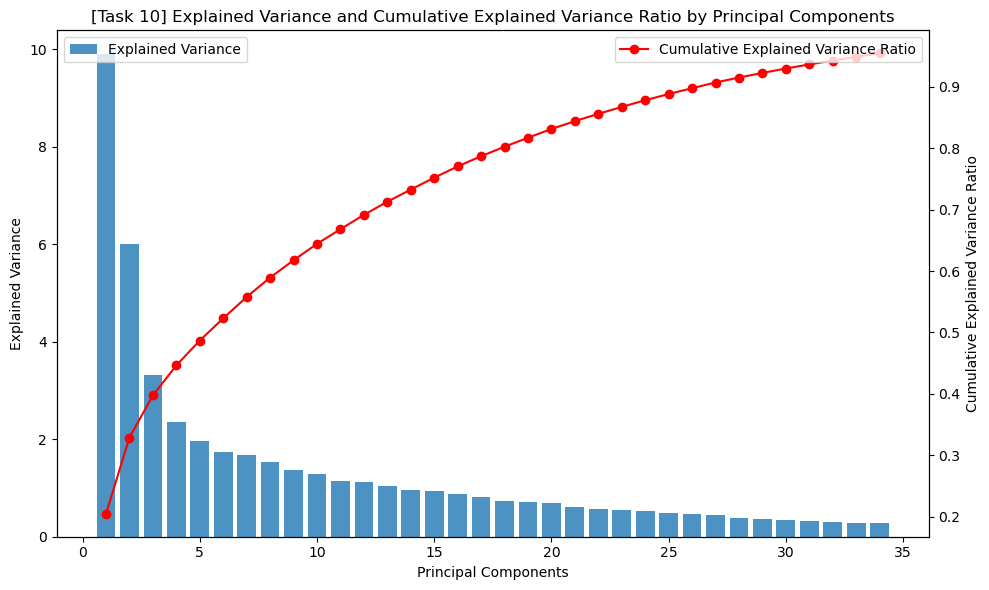

In [9]:
pca,selected_features_df = feature_selection_PCA(selected_features,num_components=0.95)
# Create figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot explained variance
ax1.bar(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_, alpha=0.8, label='Explained Variance')
ax1.set_xlabel('Principal Components')
ax1.set_ylabel('Explained Variance')
ax1.set_title('[Task 10] Explained Variance and Cumulative Explained Variance Ratio by Principal Components')

# Create a secondary axis for cumulative explained variance ratios
ax2 = ax1.twinx()

# Plot cumulative explained variance ratios
ax2.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', color='red', label='Cumulative Explained Variance Ratio')
ax2.set_ylabel('Cumulative Explained Variance Ratio')

# Display legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjust layout
fig.tight_layout()

plt.savefig('Task10_PCA.png', dpi=300)

# Show the plot
plt.show()

In [10]:
# Step 5: Define the classification models and their respective hyperparameter grids
models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000), {'C': [0.1, 1, 10]}),  # Can adjust 'C' to control model complexity. Higher values of 'C' may increase overfitting.
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [5, 10],'bootstrap':[True,False],'max_depth': [1,2],'min_samples_leaf':[1,2,4],'min_samples_split':[2,3,4,5],'max_features':['auto','sqrt']}),  # Can adjust 'max_depth', 'min_samples_leaf', 'min_samples_split', and 'max_features' to control tree complexity. Increasing these parameters or reducing 'bootstrap' may help reduce overfitting.
    'Decision Tree': (DecisionTreeClassifier(), {'criterion':['gini','entropy'],'max_depth': [1,2],'min_samples_leaf':[1,2,4],'min_samples_split':[2,3,4,5]}),  # Can adjust 'max_depth', 'min_samples_leaf', and 'min_samples_split' to control tree complexity. Increasing these parameters may help reduce overfitting.
    'AdaBoost': (AdaBoostClassifier(), {'n_estimators': [5, 10],'learning_rate':[0.01,0.1,1]}),  # Can adjust 'n_estimators' and 'learning_rate' to control model complexity. Increasing these parameters may increase overfitting.
    'Gradient Boosting': (GradientBoostingClassifier(), {'n_estimators': [5, 10, 15],'max_depth':[1,2],'min_samples_leaf':[1,2,4],'min_samples_split':[2,3,4,5],'learning_rate':[0.01,0.1,1]}),  # Can adjust 'max_depth', 'min_samples_leaf', 'min_samples_split', and 'learning_rate' to control model complexity. Increasing these parameters may increase overfitting.
    'SVM': (SVC(), {'C': [0.1, 1], 'gamma':[1,0.1,0.01,0.001], 'kernel': ['linear', 'rbf']}),  # Can adjust 'C' and 'gamma' to control model complexity. Higher values of 'C' may increase overfitting, while lower values may reduce it.
    'K-Nearest Neighbors': (KNeighborsClassifier(), {'n_neighbors': [1,3, 5,7]}),  # Can adjust 'n_neighbors' to control model complexity. Lower values may increase overfitting, while higher values may reduce it.
    'MLP': (MLPClassifier(max_iter=1000), {'hidden_layer_sizes': [(1,)],'activation':['tanh','relu','logistic'],'alpha':[0.0001,0.05]}),  # Can adjust 'alpha' and 'hidden_layer_sizes' to control model complexity. Higher values of 'alpha' or increasing the number of nodes in 'hidden_layer_sizes' may increase overfitting.
    #'Gaussian Mixture': (GaussianMixture(), {'n_components': [2, 4, 6], 'covariance_type': ['full', 'tied', 'diag', 'spherical']}),
}


In [11]:
# Step 6: Perform features selection and grid search in kfold
k = 5  # Number of folds
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
X = selected_features

fold = 1
df_list = []
for train_index, test_index in kf.split(X,y):
    print(f"Running fold {fold}...")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Step 7: Perform grid search for each model and keep the best estimator
    best_estimators = {}
    grid_results = {}
    for name, (model, param_grid) in models.items():
        #print(f"Running Grid Search for {name}...")
        grid_search = GridSearchCV(model, param_grid, cv=5)
        grid_search.fit(X_train_pca, y_train)
        grid_results[name] = grid_search.best_score_
        best_estimators[name] = grid_search.best_estimator_
        
    train_score = {}
    test_score = {}
    for name, model in best_estimators.items():
        #print(f"Evaluating {name} using {k}-fold cross-validation...")
        model.fit(X_train_pca,y_train)
        # Evaluate the pipeline
        train_score[name] = accuracy_score(y_train, model.predict(X_train_pca))
        test_score[name] = accuracy_score(y_test, model.predict(X_test_pca))
    
    #bagging_model = BaggingClassifier(best_estimators['Logistic Regression'], n_estimators=10)
    #bagging_model.fit(X_train_pca,y_train)
    #train_score['Bagging_LR'] = accuracy_score(y_train, bagging_model.predict(X_train_pca))
    #test_score['Bagging_LR'] = accuracy_score(y_test, bagging_model.predict(X_test_pca))
    
    #stacking_model = StackingClassifier(estimators=list(best_estimators.items()))
    #stacking_model.fit(X_train_pca,y_train)
    #train_score['Stacking_All'] = accuracy_score(y_train, stacking_model.predict(X_train_pca))
    #test_score['Stacking_All'] = accuracy_score(y_test, stacking_model.predict(X_test_pca))
        
    # Create a DataFrame from the results dictionary
    df_list.append(pd.DataFrame.from_dict(train_score, orient='index', columns=['train_fold'+str(fold)]))
    df_list.append(pd.DataFrame.from_dict(test_score, orient='index', columns=['test_fold'+str(fold)]))
    fold +=1
# Concatenate the list of DataFrames into a single DataFrame
results_df = pd.concat(df_list, axis=1)
results_df['train_avg'] = results_df.iloc[:, 0:len(df_list):2].mean(axis=1)
results_df['train_sd'] = results_df.iloc[:, 0:len(df_list):2].std(axis=1)
results_df['test_avg'] = results_df.iloc[:, 1:len(df_list):2].mean(axis=1)
results_df['test_sd'] = results_df.iloc[:, 1:len(df_list):2].std(axis=1)

Running fold 1...


c:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
c:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
c:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
c:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
c:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\ne

Running fold 2...


c:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
c:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
c:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
c:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
c:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\ne

Running fold 3...


c:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
c:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
c:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
c:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
c:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\ne

Running fold 4...


c:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
c:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
c:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
c:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
c:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\ne

Running fold 5...


c:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
c:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
c:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
c:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
c:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\ne

In [12]:
# Save the results to a CSV file
results_df.to_csv('Task10_ML_res.csv')

# Print the final DataFrame
print(results_df[['train_avg','train_sd','test_avg','test_sd']])

                     train_avg  train_sd  test_avg   test_sd
Logistic Regression   0.781647  0.021666  0.704991  0.056909
Random Forest         0.701902  0.048320  0.590374  0.114398
Decision Tree         0.706323  0.028648  0.639037  0.082306
AdaBoost              0.721394  0.043439  0.632977  0.098759
Gradient Boosting     0.837161  0.124271  0.554011  0.100040
SVM                   0.804249  0.024066  0.662923  0.041606
K-Nearest Neighbors   0.768011  0.049831  0.614439  0.089335
MLP                   0.805878  0.158087  0.554545  0.099124


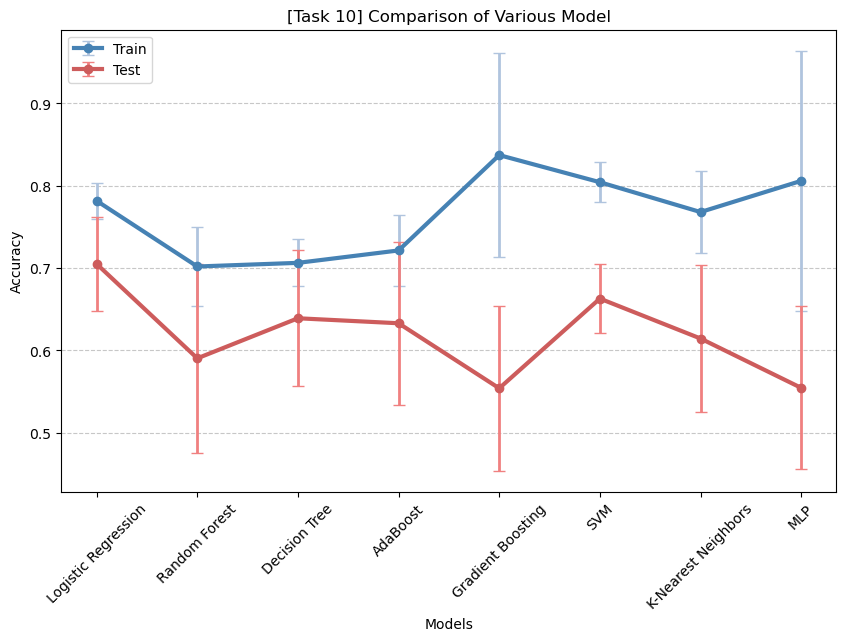

In [13]:
models = results_df.index.tolist()
train_avg = results_df['train_avg']
train_sd = results_df['train_sd']
test_avg = results_df['test_avg']
test_sd = results_df['test_sd']
# Set the figure size
plt.figure(figsize=(10, 6))

# Plot train scores with error bars
plt.errorbar(models, train_avg, yerr=train_sd, label='Train', marker='o', capsize=4,
            color='steelblue', linewidth=3, ecolor='lightsteelblue', elinewidth=2)
plt.errorbar(models, test_avg, yerr=test_sd, label='Test', marker='o', capsize=4,
            color='indianred', linewidth=3, ecolor='lightcoral', elinewidth=2)

# Set labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('[Task 10] Comparison of Various Model')

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

plt.savefig('Task10_res.png', dpi=300)

# Add legend
plt.legend()

# Show the plot
plt.show()
